Epoch 1/200, Loss: 0.6248
Epoch 2/200, Loss: 0.0481
Epoch 3/200, Loss: 0.0171
Epoch 4/200, Loss: 0.0121
Epoch 5/200, Loss: 0.0097
Epoch 6/200, Loss: 0.0096
Epoch 7/200, Loss: 0.0084
Epoch 8/200, Loss: 0.0080
Epoch 9/200, Loss: 0.0075
Epoch 10/200, Loss: 0.0067
Epoch 11/200, Loss: 0.0065
Epoch 12/200, Loss: 0.0076
Epoch 13/200, Loss: 0.0065
Epoch 14/200, Loss: 0.0071
Epoch 15/200, Loss: 0.0066
Epoch 16/200, Loss: 0.0067
Epoch 17/200, Loss: 0.0072
Epoch 18/200, Loss: 0.0062
Epoch 19/200, Loss: 0.0057
Epoch 20/200, Loss: 0.0054
Epoch 21/200, Loss: 0.0057
Epoch 22/200, Loss: 0.0054
Epoch 23/200, Loss: 0.0056
Epoch 24/200, Loss: 0.0069
Epoch 25/200, Loss: 0.0060
Epoch 26/200, Loss: 0.0054
Epoch 27/200, Loss: 0.0056
Epoch 28/200, Loss: 0.0047
Epoch 29/200, Loss: 0.0053
Epoch 30/200, Loss: 0.0050
Epoch 31/200, Loss: 0.0053
Epoch 32/200, Loss: 0.0049
Epoch 33/200, Loss: 0.0056
Epoch 34/200, Loss: 0.0056
Epoch 35/200, Loss: 0.0049
Epoch 36/200, Loss: 0.0051
Epoch 37/200, Loss: 0.0048
Epoch 38/2

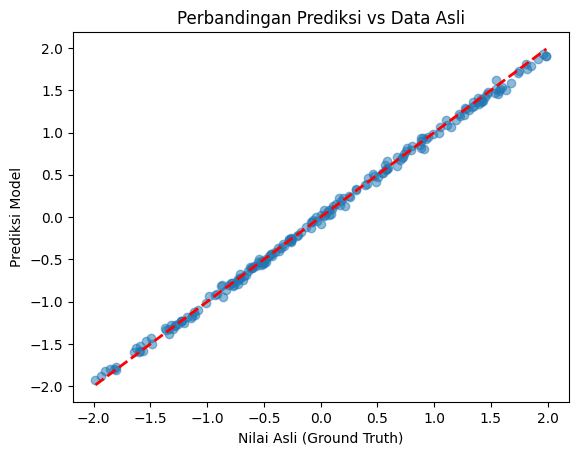

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv(r'secondhanddataset.csv')

target = 'current price'

# Separate features and target
X = data.drop(columns=[target])
y = data[target].values.reshape(-1, 1)

# Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X = preprocessor.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=1024):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(0.05)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.out = nn.Linear(hidden_size // 4, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        return self.out(x)

# Initialize model, loss, optimizer
input_size = X_train.shape[1]
model_pt = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.0001)

# Training Loop
num_epochs = 200
best_loss = float('inf')
patience = 20
counter = 0

for epoch in range(num_epochs):
    model_pt.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_pt(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Early Stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


# Evaluation
model_pt.eval()
with torch.no_grad():
    y_pred = model_pt(X_test_tensor).numpy()

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'\nMSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-squared: {r2:.4f}')

# Plotting
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Nilai Asli (Ground Truth)")
plt.ylabel("Prediksi Model")
plt.title("Perbandingan Prediksi vs Data Asli")
plt.show()


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6999
Epoch 2/200
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0844

C:\Users\muham\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0783
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0258
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0096
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0088
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0077
Epoch 13/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074
Epoch 14/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060
Epoch 15/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075
Epoch 16/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076
Epoch 17

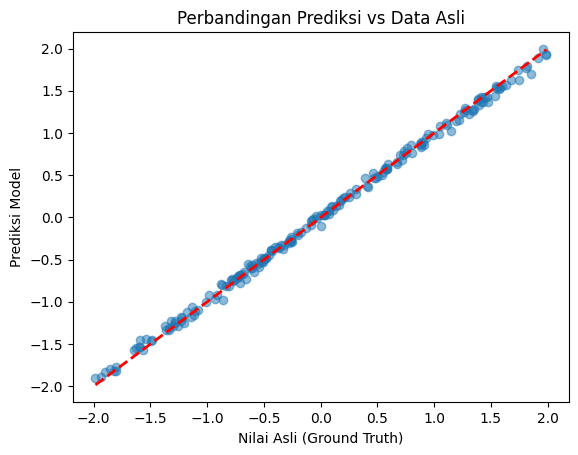

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv(r'secondhanddataset.csv')

target = 'current price'

# Separate features and target
X = data.drop(columns=[target])
y = data[target].values.reshape(-1, 1)

# Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X = preprocessor.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Define the model
class MLP(tf.keras.Model):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.fc2 = tf.keras.layers.Dense(hidden_size // 2, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.05)
        self.fc3 = tf.keras.layers.Dense(hidden_size // 4, activation='relu')
        self.fc4 = tf.keras.layers.Dense(1)

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.dropout1(x, training=training)
        x = self.fc2(x)
        x = self.dropout2(x, training=training)
        x = self.fc3(x)
        return self.fc4(x)

# Initialize model
input_size = X_train.shape[1]
hidden_size = 1024
model = MLP(input_size)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse'
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Training loop
num_epochs = 200
history = model.fit(train_dataset, epochs=num_epochs, callbacks=callbacks, verbose=1)

# Evaluate the model
loss = model.evaluate(test_dataset)
print(f'\nLoss: {loss:.4f}')

# Predict
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'\nMSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-squared: {r2:.4f}')

# Plotting results
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # Perfect fit line
plt.xlabel("Nilai Asli (Ground Truth)")
plt.ylabel("Prediksi Model")
plt.title("Perbandingan Prediksi vs Data Asli")
plt.show()

In [5]:
# === Sample Test for Prediction Comparison (TF vs PyTorch) ===
import random

# Pick a random sample from test set
random_idx = random.randint(0, X_test.shape[0] - 1)
sample_input = X_test[random_idx].reshape(1, -1)
true_price = scaler_y.inverse_transform(y_test[random_idx].reshape(1, -1))[0][0]

# --- TensorFlow Prediction ---
sample_tf_pred_scaled = model.predict(sample_input)
sample_tf_pred = scaler_y.inverse_transform(sample_tf_pred_scaled)[0][0]

# --- PyTorch Prediction ---
sample_tensor = torch.tensor(sample_input, dtype=torch.float32)
model_pt.eval()
with torch.no_grad():
    sample_pt_pred_scaled = model_pt(sample_tensor).numpy()
sample_pt_pred = scaler_y.inverse_transform(sample_pt_pred_scaled)[0][0]

# Show Results
print("=== Sample Prediction Comparison ===")
print(f"True Price           : {true_price:.2f}")
print(f"PyTorch Prediction   : {sample_pt_pred:.2f}")
print(f"TensorFlow Prediction: {sample_tf_pred:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
=== Sample Prediction Comparison ===
True Price           : 308867.00
PyTorch Prediction   : 302173.16
TensorFlow Prediction: 304733.94


# ANALISIS HASIL DARI REGRESSION

**Hasil dari PyTorch:**

- **MSE**: 0.0021
- **RMSE**: 0.0464
- **R-squared**: 0.9980

**Hasil dari Tensorflow:**

- **MSE**: 0.0032
- **RMSE**: 0.0563
- **R-squared**: 0.9970

**Hasil dari Prediction:**
- **True Price**: 403886.50
- **PyTorch Prediction**: 410002.88
- **TensorFlow Prediction**: 408085.59



Untuk MSE dan RSME keduanya sangat persis sekali, apalagi R-squared yang hasilnya juga hampir sama dan hampir 1 sehingga modelnya termasuk sangat bagus. 
Untuk hasil Prediction, keduanya saling menyaingi namun pada sample yang ada, Tensorflow sangat mendekati dengan actual.



# BENTUK PERSAMAAN DARI MSE/RMSE/$R^2$
Mean Squared Error (MSE) 
-
Mean Squared Error (MSE) mengukur rata-rata kuadrat kesalahan (error) antara nilai yang diprediksi dengan nilai aktual. MSE memberikan gambaran seberapa besar nilai yang diprediksi berbeda dari nilai aktual.

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

**Keterangan:**

- \($ n $\)         : Jumlah data
- \($ y_i $\)       : Nilai aktual
- \($ \hat{y}_i $)  : Nilai prediksi


Root Mean Squared Error (RMSE)
-
Root Mean Squared Error (RMSE) adalah akar kuadrat dari MSE. RMSE memberikan ukuran kesalahan dalam satuan yang sama dengan data asli, sehingga lebih mudah diinterpretasikan.

$$
RMSE = \sqrt{MSE}
$$

Atau dengan substitusi,

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

**Keterangan:**

- \($ n $\)         : Jumlah data
- \($ y_i $\)       : Nilai aktual
- \($ \hat{y}_i $)  : Nilai prediksi

Koefisien Determinasi (R²)
-
Koefisien determinasi (R²) mengukur proporsi variabilitas dalam nilai aktual yang dapat dijelaskan oleh model. Nilai R² berkisar antara 0 hingga 1, di mana nilai yang lebih tinggi menunjukkan model yang lebih baik.

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

Dengan,

$$
SS_{res} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

$$
SS_{tot} = \sum_{i=1}^{n} (y_i - \overline{y})^2
$$

**Keterangan:**
- \($ SS_{res} $\): Jumlah kuadrat residu (sum of squared residuals)
- \($ SS_{tot} $\): Jumlah kuadrat total (sum of squared total)
- \($ \overline{y} $\): Rata-rata nilai aktual
